In [1]:
# load in our packages
# Import cell

import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import scipy
from scipy.stats import pearsonr, spearmanr

# from pymatgen.core.structure import Structure
# from pymatgen.core.composition import Composition

# from matminer.datasets import load_dataset
# from matminer.featurizers.composition.composite import ElementProperty
# from matminer.featurizers.composition.element import ElementFraction
# from matminer.featurizers.structure.rdf import RadialDistributionFunction
# from matminer.featurizers.structure.matrix import CoulombMatrix, SineCoulombMatrix


from scipy.stats import pearsonr, skew, kurtosis
from scipy.spatial import distance
from scipy.interpolate import CubicSpline
# from scipy.stats import skew, kurtosis

#from sisso import SISSO
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.metrics import f1_score
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# plt.style.use('../../modules/files/plot_style.mplstyle')

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

In [2]:
def get_rmse(actual, pred):
    return np.mean([(actual[i]-pred[i])**2 for i in range(len(actual))])**0.5

def get_abs_per(actual, pred):
    return np.mean([np.absolute((actual[i]-pred[i])/actual[i] * 100) for i in range(len(actual))])

def run_cv(n_folds, model, model_type, X_train, y_train, stratify=False):
    """
    Args:
        n_folds (int) : how many folds of CV to do
        model (sklearn Model) : what model do we want to fit
        model_type: 'cl' for classifier, 'rgr' for regressor
        X_train (np.array) : feature matrix
        y_train (np.array) : target array
        stratify (bool) : if True, use stratified CV, otherwise, use random CV
        
    Returns:
        a dictionary with scores from each fold for training and validation
            {'train' : [list of training scores],
             'val' : [list of validation scores]}
            - the length of each list = n_folds
    """
    if stratify:
        folds = StratifiedKFold(n_splits=n_folds).split(X_train, y_train)
    else:
        folds = KFold(n_splits=n_folds).split(X_train, y_train)

    train_scores, val_scores = [], []
    train_scores_per, val_scores_per = [], []
    
    for k, (train, val) in enumerate(folds):

        X_train_cv = X_train[train]
        y_train_cv = y_train[train]

        X_val_cv = X_train[val]
        y_val_cv = y_train[val]

        model.fit(X_train_cv, y_train_cv)

        y_train_cv_pred = model.predict(X_train_cv)
        y_val_cv_pred = model.predict(X_val_cv)

        if model_type == 'rgr':
          train_acc = get_rmse(y_train_cv, y_train_cv_pred)
          val_acc = get_rmse(y_val_cv, y_val_cv_pred)
          
          train_acc_per = get_abs_per(y_train_cv, y_train_cv_pred)
          val_acc_per = get_abs_per(y_val_cv, y_val_cv_pred)
          
          #print('\nFold %i' % k)
          #print('Train acc = %.3f' % train_acc)
          #print('Val acc = %.3f' % val_acc)

          train_scores.append(train_acc)
          val_scores.append(val_acc)
          
          train_scores_per.append(train_acc_per)
          val_scores_per.append(val_acc_per)
          
        elif model_type == 'cl':
          train_acc = f1_score(y_train_cv, y_train_cv_pred)
          val_acc = f1_score(y_val_cv, y_val_cv_pred)

          train_scores.append(train_acc)
          val_scores.append(val_acc)

    if model_type == 'rgr':
      print('\n%i Folds' % n_folds)
      print('Mean training error = %.3f +/- %.4f' % (np.mean(train_scores), np.std(train_scores)))
      print('Mean validation error = %.3f +/- %.4f\n' % (np.mean(val_scores), np.std(val_scores)))
      
      print('Mean training percentage error = %.3f %% +/- %.4f' % (np.mean(train_scores_per), np.std(train_scores_per)))
      print('Mean validation percentage error = %.3f %% +/- %.4f' % (np.mean(val_scores_per), np.std(val_scores_per)))
    
    elif model_type == 'cl':
      print('\n%i Folds' % n_folds)
      print('Mean training f1 score = %.3f +/- %.4f' % (np.mean(train_scores), np.std(train_scores)))
      print('Mean validation f1 score = %.3f +/- %.4f\n' % (np.mean(val_scores), np.std(val_scores)))

    return {'train' : train_scores,
            'val' : val_scores
            }

In [3]:
def model_implementation(model, model_type, param_grid, X_train, y_train):

  if model_type == 'cl':
    scoring = 'f1'
  elif model_type == 'rgr':
    scoring = 'neg_mean_squared_error'

  model_name = type(model).__name__

  gs = GridSearchCV(model, param_grid, scoring = scoring, return_train_score = True)
  gs.fit(X_train, y_train)

  print('\nTuning hyperparameters for %s model: \n' % model_name)
  print('Best parameter: \n', gs.best_params_)
  print('Best score: \n', gs.best_score_)

  print('\nFitting to best %s model:' % model_name)
  n_folds = 5
  stratify = False

  model = gs.best_estimator_

  d_scores = run_cv(n_folds=n_folds, model=model, model_type = model_type, X_train=X_train, y_train=y_train, stratify=stratify)

  return model, d_scores

In [4]:
path = "../data/SNL" 

X_matrix_path = os.path.join(path, 'X_matrix.csv')
rstate = 1
df = pd.read_csv(X_matrix_path)

target = ['index_lifetime']
non_features = ['Unnamed: 0', 'cell ID', 'Cahtode', 'Anode', 'Source', 'form factor','Charge Rate']

# df['LFP?'] = np.where(df['Cahtode']=='LFP', 1, 0)
# df['NCA?'] = np.where(df['Cahtode']=='NCA', 1, 0)
# df['NMC?'] = np.where(df['Cahtode']=='NMC', 1, 0)

columns = list(df)
features = [f for f in columns if f not in target if f not in non_features]
X_unscaled = df[features].values
y = df[target].values

class_column = 'Cahtode'

X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X_unscaled) 

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify = df['Cahtode'], random_state= rstate)
print(columns)

['Unnamed: 0', 'cell ID', 'Cahtode', 'Anode', 'Source', 'Ah', 'form factor', 'Temp', 'max soc', 'min soc', 'Charge rate', 'Discharge Rate', 'Mean_Q10-100', 'Minimum_Q10-100', 'Variance_Q10-100', 'Skewness_Q10-100', 'Kurt_Q10-100', 'index_lifetime', 'slope_2to100', 'intercept_2to100', 'slope_91to100', 'intercept_91to100']


# Linear Model Implementation

In [5]:
model_type = 'rgr'
#Linear Model
lr = Lasso()

#initially checking order of alpha value
print('\nFinding the best order of alpha value out of (0.1, 1, 10, 100, 1000): \n')
param_grid_lr = {'alpha' : [0.1 , 1, 10, 100, 1000],
            'fit_intercept': [True, False]}

gs = GridSearchCV(lr, param_grid_lr, scoring = 'neg_mean_squared_error', return_train_score = True, )
gs.fit(X_train, y_train)

print('Best parameter: \n', gs.best_params_)
print('Best score: \n', gs.best_score_)


#optimizing alpha value between 10 and 100
print('\nFinding the best alpha value between 10 and 100: \n')
param_grid = {'alpha' : np.linspace(10, 100, num= 10)}

lr_best_estimator, lr_scores = model_implementation(lr, model_type, param_grid, X_train, y_train)


Finding the best order of alpha value out of (0.1, 1, 10, 100, 1000): 

Best parameter: 
 {'alpha': 100, 'fit_intercept': True}
Best score: 
 -760028.9281701844

Finding the best alpha value between 10 and 100: 


Tuning hyperparameters for Lasso model: 

Best parameter: 
 {'alpha': 70.0}
Best score: 
 -749445.315691069

Fitting to best Lasso model:

5 Folds
Mean training error = 721.103 +/- 144.4876
Mean validation error = 743.144 +/- 444.0522

Mean training percentage error = 64.169 % +/- 12.3400
Mean validation percentage error = 74.532 % +/- 41.9183



# Non-Linear Regression Models Implementation

## Decision Tree Model

In [8]:
model_type = 'rgr'
dtree = DecisionTreeRegressor(random_state = rstate)

#initially checking order of alpha value
param_grid_dtree = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': [2, 4, 6, 8, 10, 20, 30, 40 ,50],
    'min_samples_split': [2, 4, 6, 8, 10, 20, 30, 40, 50],
    'max_features': ['auto', 'sqrt', 'log2']
}

dtree_best_estimator, dtree_scores = model_implementation(dtree, model_type, param_grid_dtree, X_train, y_train)


Tuning hyperparameters for DecisionTreeRegressor model: 

Best parameter: 
 {'criterion': 'absolute_error', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_split': 2}
Best score: 
 -566055.2673076923

Fitting to best DecisionTreeRegressor model:

5 Folds
Mean training error = 684.920 +/- 101.6166
Mean validation error = 689.113 +/- 301.9583

Mean training percentage error = 43.112 % +/- 8.0207
Mean validation percentage error = 56.724 % +/- 17.8639


## Gradient Boosting Decision Tree Regressor

In [9]:
model_type = 'rgr'
gdbt = GradientBoostingRegressor(random_state = rstate)
param_grid_gdbt = {
              'n_estimators' : [1, 2, 4, 6, 8, 10, 20, 30, 40, 50],
              'learning_rate' : [0.001, 0.01, 0.1, 1],
              'max_depth' : [2, 4, 6, 8, 10, 20, 30, 40 ,50]
              }

gdbt_best_estimator, gdbt_scores = model_implementation(gdbt, model_type, param_grid_gdbt, X_train, y_train)


Tuning hyperparameters for GradientBoostingRegressor model: 

Best parameter: 
 {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}
Best score: 
 -895044.5200788153

Fitting to best GradientBoostingRegressor model:

5 Folds
Mean training error = 203.882 +/- 41.2791
Mean validation error = 791.864 +/- 517.6831

Mean training percentage error = 29.999 % +/- 5.6846
Mean validation percentage error = 70.401 % +/- 28.1518


## Adaboosting Decision Tree Regressor

In [10]:
model_type = 'rgr'
adbt = AdaBoostRegressor(base_estimator = dtree_best_estimator, random_state = rstate)

param_grid_adbt = {
              'n_estimators' : [1, 2, 4, 6, 8, 10, 20, 30, 40, 50],
              'learning_rate' : [0.001, 0.01, 0.1, 1],
              }

adbt_best_estimator, adbt_scores = model_implementation(adbt, model_type, param_grid_adbt, X_train, y_train)


Tuning hyperparameters for AdaBoostRegressor model: 

Best parameter: 
 {'learning_rate': 0.1, 'n_estimators': 20}
Best score: 
 -760953.8647435898

Fitting to best AdaBoostRegressor model:

5 Folds
Mean training error = 588.406 +/- 161.3543
Mean validation error = 759.440 +/- 429.1916

Mean training percentage error = 44.882 % +/- 7.5779
Mean validation percentage error = 62.866 % +/- 25.0112


## Support Vector Regressor Model

In [13]:
model_type = 'rgr'

svr = SVR()
param_grid_svr = {
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'] + [0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 1]
}

svr_best_estimator, svr_scores = model_implementation(svr, model_type, param_grid_svr, X_train, y_train)


Tuning hyperparameters for SVR model: 

Best parameter: 
 {'C': 1, 'epsilon': 0.01, 'gamma': 1, 'kernel': 'poly'}
Best score: 
 -1349304.8431809745

Fitting to best SVR model:

5 Folds
Mean training error = 528.357 +/- 102.7111
Mean validation error = 1020.514 +/- 554.8486

Mean training percentage error = 31.736 % +/- 9.6683
Mean validation percentage error = 86.666 % +/- 33.2187


## Random Forest Regressor

In [11]:
model_type = 'rgr'
rndmft = RandomForestRegressor()

param_grid_rndmft = {'n_estimators' : [1, 2, 4, 6, 8, 10, 20, 30, 40, 50],
                     'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
                     'max_depth': [2, 4, 6, 8, 10, 20, 30, 40 ,50],
                     'min_samples_split': [2, 4, 6, 8, 10, 20, 30, 40, 50]
                     }

rndmft_best_estimator, rndmft_scores = model_implementation(rndmft, model_type, param_grid_rndmft, X_train, y_train)


Tuning hyperparameters for RandomForestRegressor model: 

Best parameter: 
 {'criterion': 'absolute_error', 'max_depth': 40, 'min_samples_split': 4, 'n_estimators': 2}
Best score: 
 -575660.6412660256

Fitting to best RandomForestRegressor model:

5 Folds
Mean training error = 695.303 +/- 257.5696
Mean validation error = 914.578 +/- 584.8816

Mean training percentage error = 26.662 % +/- 8.5602
Mean validation percentage error = 67.401 % +/- 36.7990


## Artificial Neural Network Model

In [12]:
model_type = 'rgr'

mlpr = MLPRegressor(max_iter=100, random_state = rstate)
param_grid_mlpr = {
              "hidden_layer_sizes": [(i,) for i in [1, 2, 4, 6, 8, 10]], 
              "activation": ["identity", "logistic", "tanh", "relu"], 
              "alpha": [0.00001,0.0001, 0.001]
              }

mlpr_best_estimator, mlpr_scores = model_implementation(mlpr, model_type, param_grid_mlpr, X_train, y_train)


Tuning hyperparameters for MLPRegressor model: 

Best parameter: 
 {'activation': 'identity', 'alpha': 1e-05, 'hidden_layer_sizes': (4,)}
Best score: 
 -4012798.407827741

Fitting to best MLPRegressor model:

5 Folds
Mean training error = 2005.723 +/- 166.7302
Mean validation error = 1930.313 +/- 535.4337

Mean training percentage error = 99.793 % +/- 0.0355
Mean validation percentage error = 99.833 % +/- 0.1225


# Non Linear Classifier Models Implementation

In [15]:
path = '../data/SNL'

#Loading main dataframe
X_matrix_path = os.path.join(path, 'X_matrix.csv')
rstate = 1
df = pd.read_csv(X_matrix_path)

# df['LFP?'] = np.where(df['Cahtode']=='LFP', 1, 0)
# df['NCA?'] = np.where(df['Cahtode']=='NCA', 1, 0)
# df['NMC?'] = np.where(df['Cahtode']=='NMC', 1, 0)

threshold_LFP = 2000
threshold_NMC = 750
threshold_NCA = 450
df['above_threshold_limit'] = np.where( ((df['index_lifetime'] >= threshold_LFP) & (df['Cahtode'] == 'LFP')) |
                                        ((df['index_lifetime'] >= threshold_NMC) & (df['Cahtode'] == 'NMC')) |
                                        ((df['index_lifetime'] >= threshold_NCA) & (df['Cahtode'] == 'NCA')), 1, 0)
# df['above_threshold_limit'] = np.where( (df['index_lifetime'] >= threshold_NMC) & (df['Cahtode'] == 'NMC'), 1, 0)
# df['above_threshold_limit'] = np.where( (df['index_lifetime'] >= threshold_NCA) & (df['Cahtode'] == 'NCA'), 1, 0)

#df.loc[df['above_threshold_limit'] == 1].head()
print('Number of points above threshold for specific chemistries:')
print('\nLFP:', len(df.loc[(df['Cahtode'] == 'LFP') & (df['above_threshold_limit'] == 1)]))
print('\nNMC:', len(df.loc[(df['Cahtode'] == 'NMC') & (df['above_threshold_limit'] == 1)]))
print('\nNCA:', len(df.loc[(df['Cahtode'] == 'NCA') & (df['above_threshold_limit'] == 1)]))

columns = list(df)
target_cl = ['above_threshold_limit']
non_features_cl = ['Unnamed: 0', 'cell ID', 'Cahtode', 'Anode', 'Source', 'form factor','Charge Rate', 'index_lifetime']

#using the tag _cl for variable names for classifer
features_cl = [f for f in columns if f not in target_cl if f not in non_features_cl]
X_unscaled_cl = df[features_cl].values
y_cl = df[target_cl].values

class_column = 'Cahtode'

X_scaler_cl = StandardScaler()
X_scaled_cl = X_scaler_cl.fit_transform(X_unscaled_cl) 

X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_scaled_cl, y_cl, 
                                                                test_size=0.2, 
                                                                stratify = df['Cahtode'], 
                                                                random_state= rstate)

Number of points above threshold for specific chemistries:

LFP: 22

NMC: 9

NCA: 12


## Decision Tree Classifier

In [17]:
model_type = 'cl'

dtc = DecisionTreeClassifier(random_state = rstate)

param_grid_dtc = {
                  'criterion': ['gini', 'entropy', 'log_loss'],
                  'max_depth': [2, 4, 6, 8, 10, 20, 30, 40 ,50],
                  'max_features': ['auto', 'sqrt', 'log2']
}

dtc_best_estimator, dtc_scores = model_implementation(dtc, model_type, param_grid_dtc, X_train_cl, y_train_cl)


Tuning hyperparameters for DecisionTreeClassifier model: 

Best parameter: 
 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto'}
Best score: 
 0.7690196078431372

Fitting to best DecisionTreeClassifier model:

5 Folds
Mean training f1 score = 0.830 +/- 0.0232
Mean validation f1 score = 0.738 +/- 0.0657



## Support Vector Classifier

In [18]:
model_type = 'cl'

svc = SVC(random_state = rstate)

param_grid_svc = {
                  'kernel': ['rbf', 'poly', 'sigmoid'],
                  'C': [0.1, 1, 10],
                  'gamma': ['scale', 'auto'] + [0.01, 0.1, 1],
                 }

svc_best_estimator, svc_scores = model_implementation(svc, model_type, param_grid_svc, X_train_cl, y_train_cl)


Tuning hyperparameters for SVC model: 

Best parameter: 
 {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
Best score: 
 0.7814285714285714

Fitting to best SVC model:

5 Folds
Mean training f1 score = 0.778 +/- 0.0057
Mean validation f1 score = 0.755 +/- 0.0348



## Logistic Regression

In [20]:
model_type = 'cl'

log_reg = LogisticRegression(random_state = rstate)

param_grid_log_reg = {
                  'penalty' : ['l1', 'l2', 'elasticnet', 'None'],
                  'C' : [0.1, 1, 10],
                  'solver' : ['liblinear', 'lbfgs']
                     }

log_reg_best_estimator, log_reg_scores = model_implementation(log_reg, model_type, param_grid_log_reg, X_train_cl, y_train_cl)


Tuning hyperparameters for LogisticRegression model: 

Best parameter: 
 {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 
 0.7183916083916084

Fitting to best LogisticRegression model:

5 Folds
Mean training f1 score = 0.741 +/- 0.0329
Mean validation f1 score = 0.730 +/- 0.0686



## Random Forest Classifier

In [25]:
model_type = 'cl'

rfc = RandomForestClassifier(random_state = rstate)

param_grid_rfc = {'n_estimators' : [1, 2, 4, 6, 8, 10, 20, 30, 40, 50],
                  'criterion': ['gini', 'entropy', 'log_loss'],
                  'max_depth': [2, 4, 6, 8, 10, 20, 30, 40 ,50],
                  'min_samples_split': [2, 4, 6, 8, 10, 20, 30, 40, 50]
                  }

rfc_best_estimator, rfc_scores = model_implementation(rfc, model_type, param_grid_rfc, X_train_cl, y_train_cl)


Tuning hyperparameters for RandomForestClassifier model: 

Best parameter: 
 {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 8, 'n_estimators': 20}
Best score: 
 0.8555128205128206

Fitting to best RandomForestClassifier model:

5 Folds
Mean training f1 score = 0.915 +/- 0.0279
Mean validation f1 score = 0.800 +/- 0.1033



## Majority Voting based ensembling of the non-linear classifiers

In [43]:
model_type = 'cl'
ensemble_cl = VotingClassifier(estimators = [('log_reg', log_reg_best_estimator),
                                             ('svm', svc_best_estimator),
                                             ('dtc', dtc_best_estimator)])

n_folds = 5
ensemble_cl_scores = run_cv(n_folds = n_folds,
                            model = ensemble_cl,
                            model_type = model_type,
                            X_train = X_train_cl,
                            y_train = y_train_cl,
                            stratify=False)


5 Folds
Mean training f1 score = 0.786 +/- 0.0123
Mean validation f1 score = 0.785 +/- 0.0396



# Prediction with primary test data

In [44]:
def pred_primary_test(model, model_type, X_train, y_train, X_test, y_test):
  
  model_name = type(model).__name__
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  
  if model_type == 'cl':
    model_accuracy = f1_score(y_test, y_pred)*100
    
  elif model_type == 'rgr':
    model_accuracy = 100 - get_abs_per(y_test, y_pred)
  
  print('\n%s\nAccuracy: %.2f' % (model_name, model_accuracy))
  return model_accuracy


In [45]:
dtc_final_score = pred_primary_test(dtc_best_estimator, model_type = 'cl', 
                                         X_train = X_train_cl, 
                                         y_train = y_train_cl,
                                         X_test = X_test_cl, 
                                         y_test = y_test_cl)

log_reg_final_score = pred_primary_test(log_reg_best_estimator, model_type = 'cl', 
                                         X_train = X_train_cl, 
                                         y_train = y_train_cl,
                                         X_test = X_test_cl, 
                                         y_test = y_test_cl)

svc_final_score = pred_primary_test(svc_best_estimator, model_type = 'cl', 
                                         X_train = X_train_cl, 
                                         y_train = y_train_cl,
                                         X_test = X_test_cl, 
                                         y_test = y_test_cl)

rfc_final_score = pred_primary_test(rfc_best_estimator, model_type = 'cl', 
                                         X_train = X_train_cl, 
                                         y_train = y_train_cl,
                                         X_test = X_test_cl, 
                                         y_test = y_test_cl)

ensemble_final_score = pred_primary_test(ensemble_cl, model_type = 'cl', 
                                         X_train = X_train_cl, 
                                         y_train = y_train_cl,
                                         X_test = X_test_cl, 
                                         y_test = y_test_cl)


DecisionTreeClassifier
Accuracy: 73.68

LogisticRegression
Accuracy: 70.59

SVC
Accuracy: 77.78

RandomForestClassifier
Accuracy: 73.68

VotingClassifier
Accuracy: 77.78


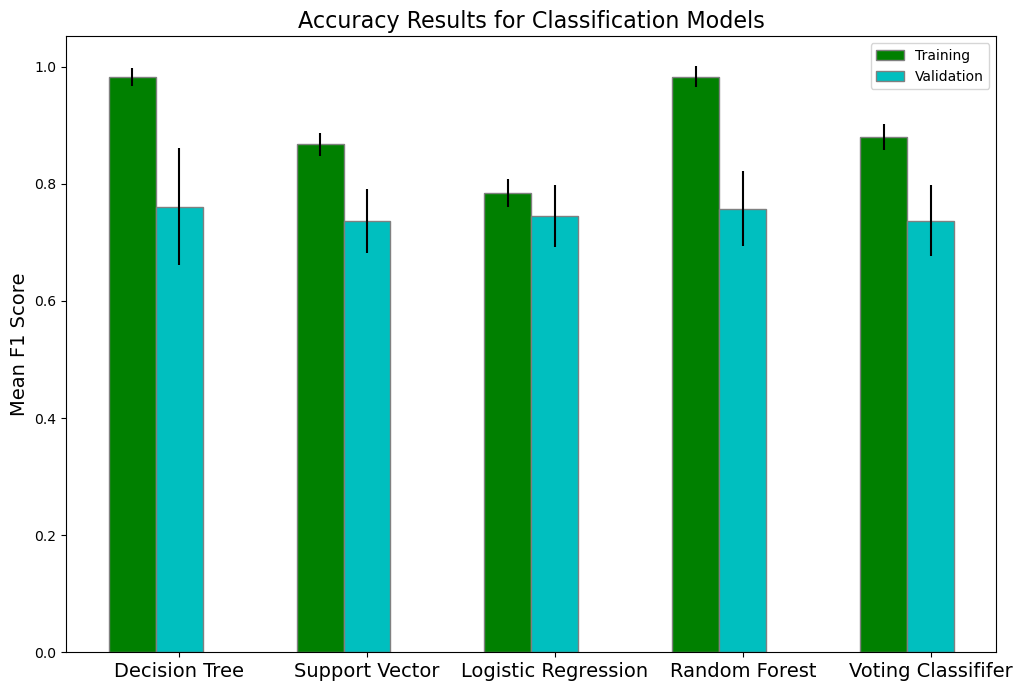

In [46]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
training = [0.982, 0.867, 0.784, 0.983, 0.88]
validation = [0.761, 0.736, 0.745, 0.757, 0.737]
t_error = [0.0157, 0.0198, 0.0243, 0.0186, 0.0223]
v_error = [0.0991, 0.0544, 0.0524, 0.0642, 0.06]

# Set position of bar on X axis
br1 = np.arange(len(training))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, training, yerr = t_error, color ='g', width = barWidth,
        edgecolor ='grey', label ='Training')
plt.bar(br2, validation, yerr = v_error, color ='c', width = barWidth,
        edgecolor ='grey', label ='Validation')
 
# Adding Xticks
# plt.xlabel('Classification model', fontweight ='bold', fontsize = 14)
plt.ylabel('Mean F1 Score', fontsize = 14)
plt.xticks([r + barWidth for r in range(len(training))],
        ['Decision Tree', 'Support Vector', 'Logistic Regression', 'Random Forest', 'Voting Classififer'], fontsize = 14)
 
plt.legend()
plt.title('Accuracy Results for Classification Models',fontsize = 16)
figure_path = '../figures'
plt.savefig(figure_path + '/Accuracy_results_cl.png')
plt.show()

# Raw Data Analysis

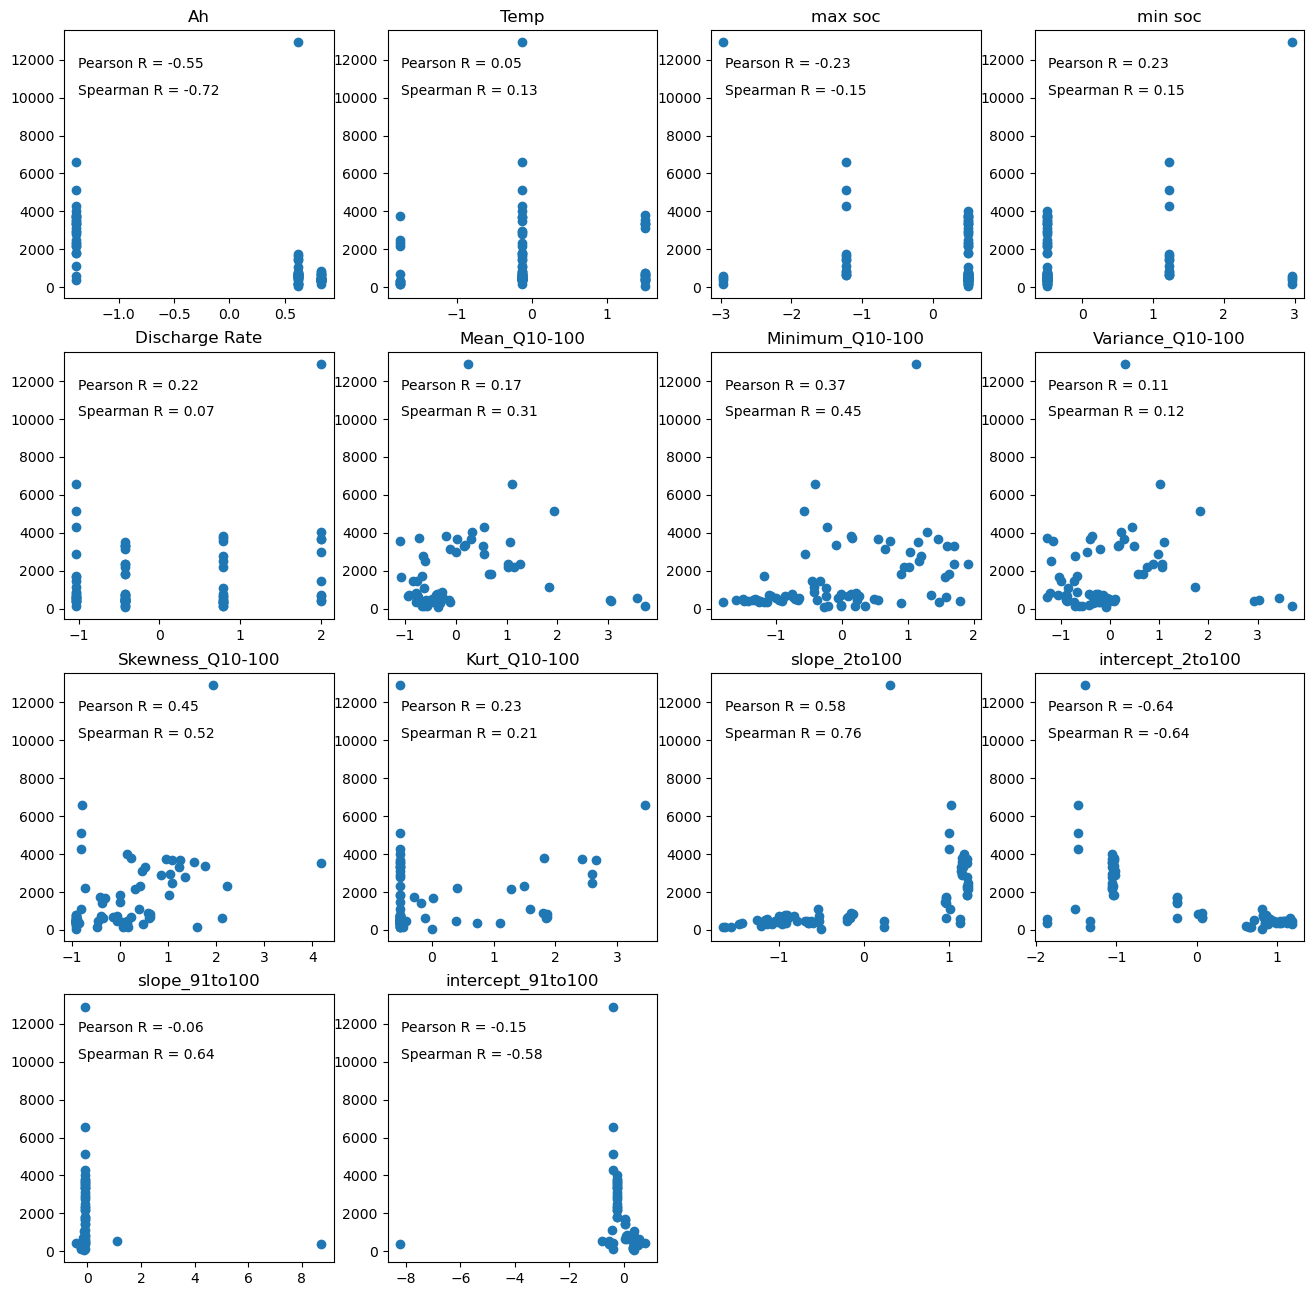

In [47]:
path = "../data/SNL"
#Loading main dataframe
X_matrix_path = os.path.join(path, 'X_matrix.csv')

rstate = 1
df = pd.read_csv(X_matrix_path)
columns = list(df)

target = ['index_lifetime']
non_features = ['Unnamed: 0', 'cell ID', 'Cahtode', 'Anode', 'Source', 'form factor','Charge rate']
features = [f for f in columns if f not in target if f not in non_features]

fig = plt.figure(figsize = (16, 16))

#sub_n = subplot number 
sub_n = 1

for f in features:
  x = df[f].values.reshape(-1, 1)
  x = StandardScaler().fit_transform(x)
  x = np.squeeze(np.asarray(x))
  y = df[target].values
  y = np.squeeze(np.asarray(y))


  ax = plt.subplot(4, 4, sub_n)
  ax.scatter(x, y)
  ax.set_title(f)
  
  transAxes = ax.transAxes

  corr_pearson, _ = pearsonr(x, y)
  corr_spearman, _ = spearmanr(x, y)

  corr_pearson = format(corr_pearson, ".2f")
  corr_spearman = format(corr_spearman, ".2f")

  ax.text(0.05, 0.9, 'Pearson R = ' + str(corr_pearson),
          verticalalignment='top', horizontalalignment='left',
          transform=transAxes)
  ax.text(0.05, 0.8, 'Spearman R = ' + str(corr_spearman),
          verticalalignment='top', horizontalalignment='left',
          transform=transAxes)

  sub_n = sub_n + 1


# Feature Importances

In [48]:
def get_features_and_their_importances(fit_model, features, X_test, y_test):
    
    r = permutation_importance(model, X_test, y_test, scoring='f1',
                         n_repeats=2, random_state=9)
    
    importances = r.importances_mean
    descending_indices = np.argsort(importances)[::-1]
    sorted_importances = [importances[i] for i in descending_indices]
    sorted_features = [features[i] for i in descending_indices]
    return dict(zip(sorted_features, sorted_importances))

In [49]:
# plot the feature importances

def plot_importances(features_and_their_importances):
    """
    Args:
        features_and_their_importances (dict):
            {feature (str) : impoddrtance (floddat)}
    Returns:
        matplotlib bar chart of sorted importances
    """
    axis_width = 1.5
    maj_tick_len = 6
    fontsize = 14
    bar_color = 'lightblue'
    align = 'center'
    label = '__nolegend__'
    
    n_features = len(features_and_their_importances)
    sorted_features = sorted(features_and_their_importances, 
                             key=features_and_their_importances.get, 
                             reverse=True)
    sorted_importances = [features_and_their_importances[f] for f in sorted_features]
    
    ax = plt.bar(range(n_features), sorted_importances,
                 color=bar_color, align=align, label=label)
    ax = plt.xticks(range(n_features), sorted_features, rotation=90)
    ax = plt.xlim([-1, n_features])
    ax = plt.ylabel('Feature Importances', fontsize=fontsize)
    ax = plt.tick_params('both', length=maj_tick_len, width=axis_width, 
                         which='major', right=True, top=True)
    ax = plt.xticks(fontsize=fontsize)
    ax = plt.yticks(fontsize=fontsize)
    ax = plt.tight_layout()
    return ax

Most important feature for DecisionTreeClassifier is: intercept_2to100

Most important feature for SVC is: slope_2to100

Most important feature for LogisticRegression is: slope_2to100

Most important feature for RandomForestClassifier is: slope_91to100

Most important feature for VotingClassifier is: slope_2to100



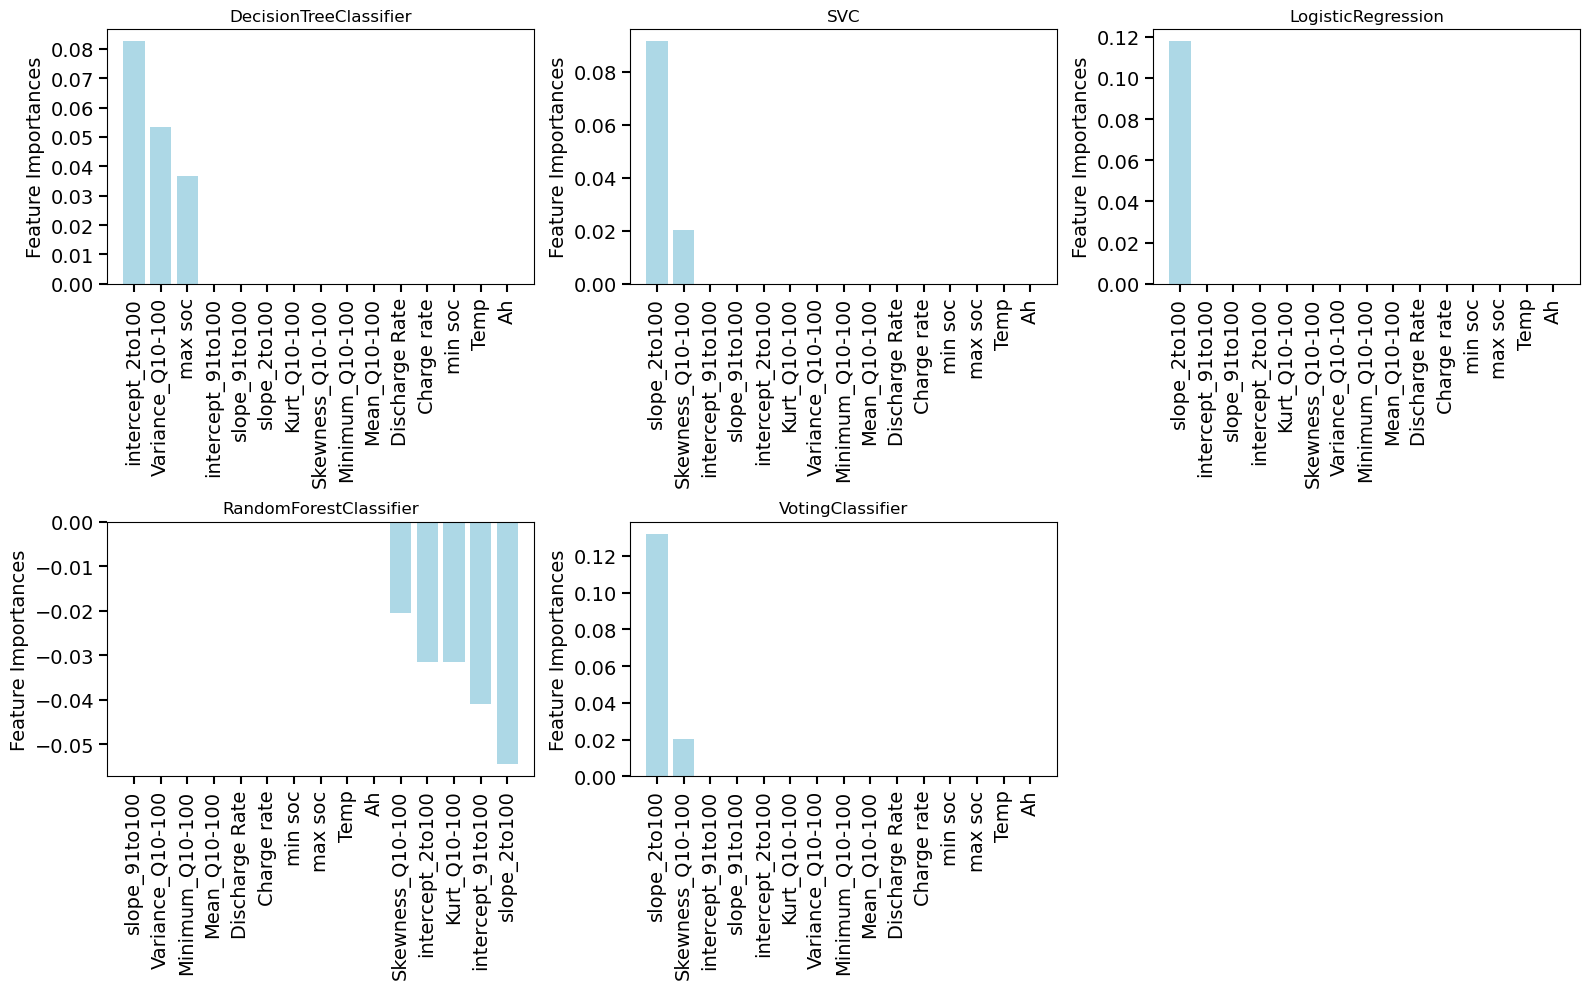

In [52]:
models_cl = [dtc_best_estimator, svc_best_estimator, log_reg_best_estimator, rfc_best_estimator, ensemble_cl]

fig = plt.figure(figsize= (16, 10))
n = len(models_cl)
sub_n = 231

for model in models_cl:
  model_name = type(model).__name__
  model_name = model_name.split('(')[0]
  features_to_importances = get_features_and_their_importances(model, features_cl, X_test_cl, y_test_cl)
  most_important = max(features_to_importances, key=features_to_importances.get)
  
  print('Most important feature for %s is: %s\n' % (model_name, most_important))
  ax = plt.subplot(sub_n)
  ax = plot_importances(features_to_importances)
  ax = plt.title(model_name)
  ax = plt.tick_params(axis='both', which='both', top=False, right=False)

  sub_n = sub_n + 1

figure_path = '../figures'
plt.savefig(figure_path+'/Feature_importances.png')

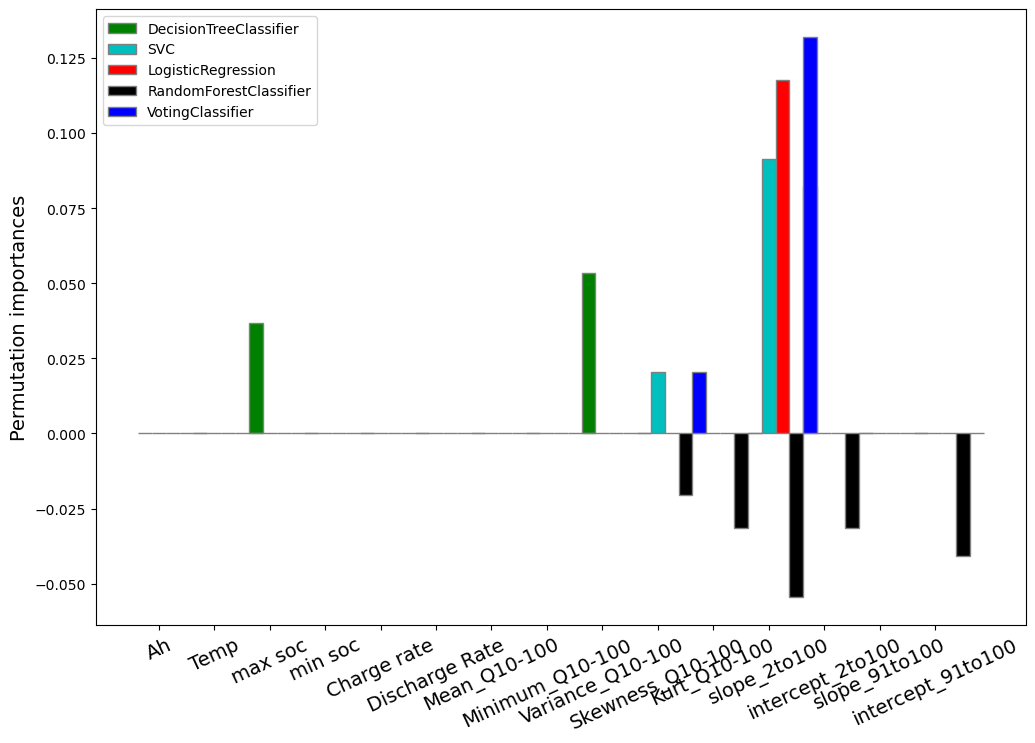

In [51]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 

# Set position of bar on X axis
br1 = np.arange(len(features_cl))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]

bar_heights=[]
# Set position of bar on X axis
# br1 = np.arange(len(training))
# br2 = [x + barWidth for x in br1]

models_cl = [dtc_best_estimator, svc_best_estimator, log_reg_best_estimator, rfc_best_estimator, ensemble_cl]

n = len(models_cl)

for model in models_cl:
  model_name = type(model).__name__
  model_name = model_name.split('(')[0]
  features_to_importances = get_features_and_their_importances(model, features_cl, X_test_cl, y_test_cl)

  bar_h = [features_to_importances[k] for k in features_cl]
  bar_heights.append(bar_h)


 
# Make the plot
plt.bar(br1, bar_heights[0], color ='g', width = barWidth,
        edgecolor ='grey', label =type(models_cl[0]).__name__)
plt.bar(br2, bar_heights[1], color ='c', width = barWidth,
        edgecolor ='grey', label =type(models_cl[1]).__name__)
plt.bar(br3, bar_heights[2], color ='r', width = barWidth,
        edgecolor ='grey', label = type(models_cl[2]).__name__)
plt.bar(br4, bar_heights[3], color ='k', width = barWidth,
        edgecolor ='grey', label = type(models_cl[3]).__name__)
plt.bar(br5, bar_heights[4], color ='b', width = barWidth,
        edgecolor ='grey', label = type(models_cl[4]).__name__)

# Adding Xticks
# plt.xlabel('Classification model', fontweight ='bold', fontsize = 14)
plt.ylabel('Permutation importances', fontsize = 14)
plt.xticks([r + barWidth for r in range(len(features_cl))], features_cl, fontsize = 14, rotation = 25)
 
plt.legend()
#plt.title('Accuracy Results for Classification Models',fontsize = 16)

figure_path = '../figures'
plt.savefig(figure_path + '/Feature_importances_v2.png')
#plt.show()